In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Some data

In [2]:
observations = 1_000_000

x, y = np.random.rand(observations), np.random.rand(observations)
ids = np.repeat(np.arange(observations//10), 10)
df = pd.DataFrame({'x': x, 'y':y, 'id':ids})

Check if polygon (red) contains these points

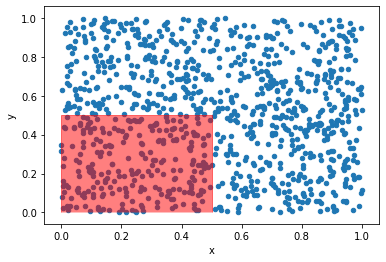

In [3]:
from matplotlib.patches import Polygon

ax = plt.gca()
df.sample(1000).plot.scatter(x='x', y='y', ax=ax)

polygon_coords = np.array([[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.5, 0.0]])

p = Polygon(polygon_coords, closed=False, fc='red', alpha=.5, ec='red')
ax.add_patch(p)

In [4]:
%load_ext memory_profiler

## GeoPandas

In [5]:
import geopandas
from shapely.geometry import Polygon

In [6]:
%%timeit

gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.x, df.y))
zone = Polygon(polygon_coords)
gdf.within(zone)

4.75 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%memit

gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.x, df.y))
zone = Polygon(polygon_coords)
gdf.within(zone)

peak memory: 3882.83 MiB, increment: 614.23 MiB


## Rustgeos

In [5]:
import rustgeos
result_rust = rustgeos.contains(polygon_coords, df.x.values, df.y.values)

In [6]:
%%timeit
rustgeos.contains(polygon_coords, df.x.values, df.y.values)

4.43 ms ± 35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%%memit
rustgeos.contains(polygon_coords, df.x.values, df.y.values)

peak memory: 112.00 MiB, increment: 0.61 MiB


## Shapely vectorized

In [5]:
from shapely.geometry import Polygon, LineString
from shapely.prepared import prep
from shapely.vectorized import contains

In [6]:
%%timeit
zone = Polygon(polygon_coords)
contains(prep(zone), df.x.values, df.y.values)

1.11 s ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
result_shapely = contains(prep(zone), df.x.values, df.y.values)

In [7]:
%%memit
zone = Polygon(polygon_coords)
contains(prep(zone), df.x.values, df.y.values)

peak memory: 653.68 MiB, increment: 0.13 MiB


## PyGeos

In [6]:
from pygeos.predicates import contains
from pygeos.creation import box, points
from pygeos.creation import Geometry

In [7]:
%%timeit

geoms = points(df.x.values, df.y.values)

xy_with_space = [' '.join([str(x) for x in a]) for a in polygon_coords]
xy_closed = xy_with_space + xy_with_space[:1]
coords_string = ', '.join(xy_closed).replace('[', '(').replace(']', ')')
poly = Geometry(f"POLYGON(({coords_string}))")

contains(poly, geoms)

2.46 s ± 39.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
result_pygeos = contains(poly, geoms)

In [8]:
%%memit

geoms = points(df.x.values, df.y.values)

xy_with_space = [' '.join([str(x) for x in a]) for a in polygon_coords]
xy_closed = xy_with_space + xy_with_space[:1]
coords_string = ', '.join(xy_closed).replace('[', '(').replace(']', ')')
poly = Geometry(f"POLYGON(({coords_string}))")

contains(poly, geoms)

peak memory: 2412.83 MiB, increment: 1164.55 MiB


## Just to be sure

In [40]:
np.testing.assert_equal(result_rust, result_shapely)
np.testing.assert_equal(result_rust, result_pygeos)

## Performance comparison

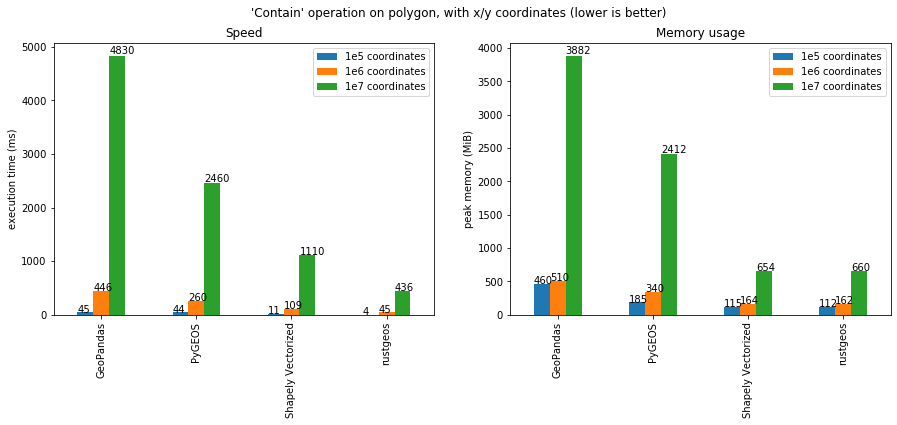

In [9]:
def annotate_bars(ax):
    for i in ax.patches:
        ax.text(i._x0, i._height*1.01, 
                str(int(i._height)), fontsize=10)
    return ax

fig, axes = plt.subplots(1, 2, figsize=(15,5))

mem_stats = pd.DataFrame({'1e5 coordinates': [460, 185, 115, 112],
                          '1e6 coordinates': [510, 340, 164, 162],
                          '1e7 coordinates': [3882, 2412, 654, 660]}, 
                         index=['GeoPandas', 'PyGEOS', 'Shapely Vectorized', 'rustgeos'])


cpu_stats = pd.DataFrame({'1e5 coordinates': [45, 44, 11.3, 4.4],
                          '1e6 coordinates': [446, 260, 109, 45],
                          '1e7 coordinates': [4830, 2460, 1110, 436]}, 
                         index=['GeoPandas', 'PyGEOS', 'Shapely Vectorized', 'rustgeos'])

cpu_stats.plot.bar(ax=axes[0])
axes[0].set_title("Speed")
axes[0].set_ylabel('execution time (ms)')
annotate_bars(axes[0])

mem_stats.plot.bar(ax=axes[1])
axes[1].set_title("Memory usage")
axes[1].set_ylabel('peak memory (MiB)')
annotate_bars(axes[1])


fig.suptitle("'Contain' operation on polygon, with x/y coordinates (lower is better)");